<a href="https://colab.research.google.com/github/stephenbeckr/convex-optimization-class/blob/master/Demos/nonconvex_example_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Descent vs Newton's method for non-convex problems

We look at a 2D problem with local minima, local maxima, and a saddle point. 
 
Terminology: for smooth unconstrained problems, a __stationary point__ is any point where the gradient is zero. We can classify stationary points into 3 types: __local min__, __local max__, and __saddle points__. We are defining saddle points as any stationary point that is not a local min nor a local  max. 
  
  
Unless we are very unlucky on the starting point, __gradient descent__ will always converge to a local minimizer (in fact, for this toy problem we discuss, this holds rigorously; see ["Gradient Descent Converges to Minimizers"](https://arxiv.org/abs/1602.04915) by Jason D. Lee, Max Simchowitz, Michael I. Jordan, Benjamin Recht; 2016).  However, gradient descent can be slowed down by the presence of the saddle point.  

__Newton's method__, on the other hand, can converge to a saddle point or even a local max! This is quite undesirable. Why does it do this? It is trying to solve the stationarity equations (which treat all local min, local max, and saddle points equally), and it finds whichever stationary point is closest. \[For real applications, no one uses plain Newton without any kind of safe guard, or at least they ought not to, but there is still a problem with saddle points\]
  
See ["Identifying and attacking the saddle point problem in high-dimensional non-convex optimization"](https://arxiv.org/abs/1406.2572) by Yann Dauphin, Razvan Pascanu, Caglar Gulcehre, Kyunghyun Cho, Surya Ganguli, Yoshua Bengio (NIPS 2014)  
  
On the other hand, at least Newton's method converges to these undesirable points very quickly...

Converted from Stephen Becker's Matlab demo to Python via Michael McCabe, March 2021

In [1]:
# Imports
# Matlab code is float64 - need to do this to match
from jax.config import config
config.update("jax_enable_x64", True)
# Normal imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# Should follow Matlab from here

# A function "f" with a saddle point
f = lambda x,y: .5*(x**2 - y**2)

# make this only a local function: multiply by Gaussian "g"
# (otherwise, it has no minimizers)
def g_builder(sigma2 = .2):
    def inner(x, y):
        return jnp.exp(-(x**2+y**2)/sigma2)
    return inner

g = g_builder()
h = lambda x,y: f(x,y)*g(x,y)

# This will need to be vmapped for batch application
# otherwise there will be index issues
F = lambda x: h(x[0], x[1])
Grad = jax.jit(jax.grad(F))
Hess = jax.jit(jax.hessian(F))

# Plotting support
X, Y = jnp.meshgrid(jnp.linspace(-1, 1, 70), jnp.linspace(-1, 1, 70))
Z = h(X, Y)-.002
norm = plt.Normalize(Z.min(), Z.max())
colors = cm.viridis(norm(Z))

Newton's method:
Iter 0, distance(x,stationary point) is 3.00e-01
Iter 1, distance(x,stationary point) is 4.81e-02
Iter 2, distance(x,stationary point) is 4.78e-03
Iter 3, distance(x,stationary point) is 2.38e-05
Iter 4, distance(x,stationary point) is 6.49e-10
Iter 5, distance(x,stationary point) is 5.55e-17

Newton's method:
Iter 0, distance(x,stationary point) is 1.00e-01
Iter 1, distance(x,stationary point) is 2.58e-02
Iter 2, distance(x,stationary point) is 3.49e-04
Iter 3, distance(x,stationary point) is 8.52e-10
Iter 4, distance(x,stationary point) is 0.00e+00
Iter 5, distance(x,stationary point) is 0.00e+00



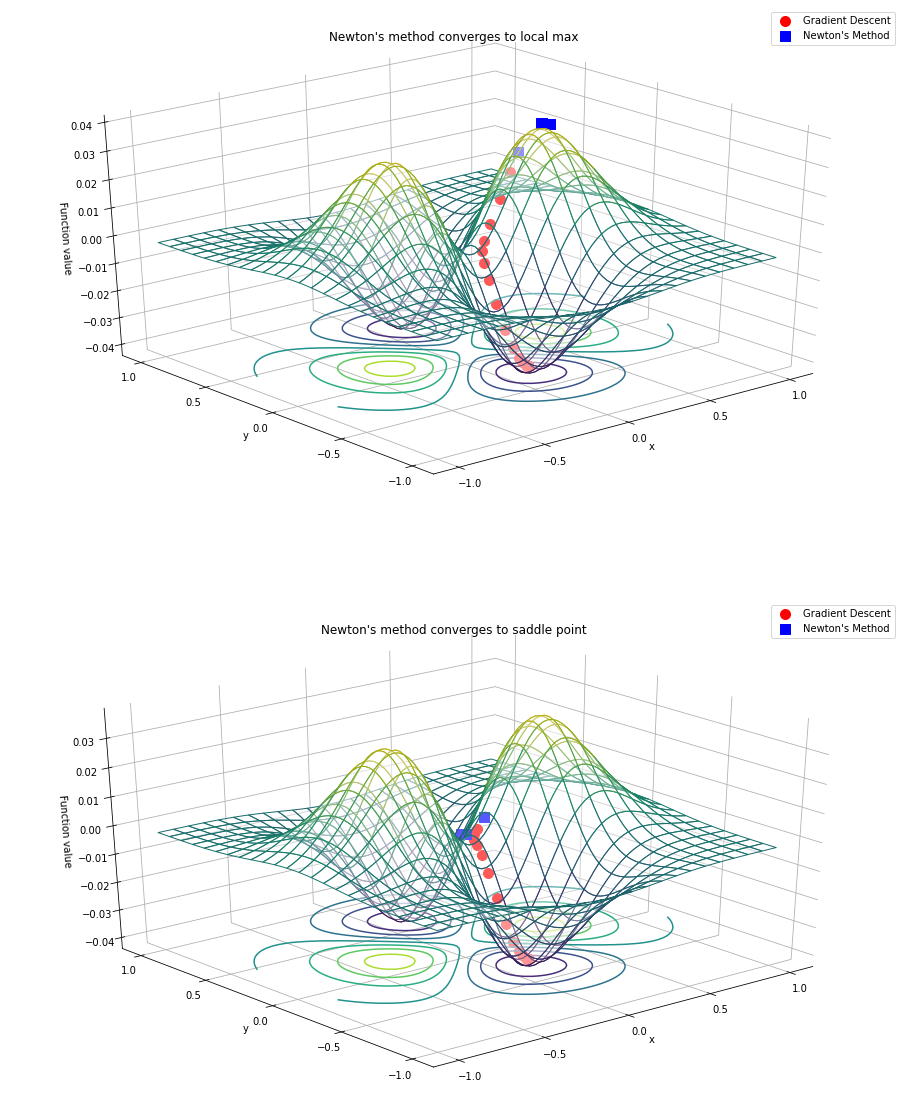

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(16, 20), subplot_kw={"projection": "3d"})

for trial in [0, 1]:
    if trial == 0:
        x0 = jnp.array([.3, -.01])
        xRef = jnp.array([.447213595499958, 0])
    else:
        x0 = jnp.array([.1, -.01])
        xRef = jnp.array([0., 0.])
        
    # Base plot - tried to mimic matlab
    surf=axes[trial].plot_surface(X, Y, Z, 
                             rstride=3, cstride=3, # Downsample contro
                             facecolors=colors,
                                )
    surf.set_facecolor((1,1,1,.35)) # Face opacity control
    axes[trial].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    axes[trial].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    axes[trial].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    axes[trial].set_xlabel('x')
    axes[trial].set_ylabel('y')
    axes[trial].set_zlabel('Function value')
    axes[trial].view_init(30, 230)
    axes[trial].set_xticks([-1, -.5, 0, .5, 1])
    axes[trial].set_yticks([-1, -.5, 0, .5, 1])
    axes[trial].contour(X, Y, Z, zdir='z', offset=jnp.min(Z))
    
    # Gradient descent
    x = x0
    maxIter = 100
    t = 1/2
    xs = []
    ys = []
    zs = []
    for k in range(maxIter):
        xs.append(x[0].item())
        ys.append(x[1].item())
        zs.append(F(x).item() +.0001)
        x = x - t*Grad(x)
    axes[trial].scatter(xs, ys, zs, c='red', s=100, label='Gradient Descent', depthshade=False)
    axes[trial].legend()
    
    # Newton's method
    x = x0
    maxIter = 5
    xs = []
    ys = []
    zs = []
    print("Newton's method:\nIter %d, distance(x,stationary point) is %.2e" %(0, jnp.linalg.norm(x)))
    for k in range(maxIter):
        xs.append(x[0].item())
        ys.append(x[1].item())
        zs.append(F(x).item() +.0001)
        x = x - jnp.linalg.solve(Hess(x), Grad(x))
        print('Iter %d, distance(x,stationary point) is %.2e' % (k+1, jnp.linalg.norm(x-xRef)))
    print('')
    axes[trial].scatter(xs, ys, zs, c='blue', marker='s', s=100, label="Newton's Method", depthshade=False)
    axes[trial].legend()
    
    
    if trial == 0:
        axes[trial].set_title("Newton's method converges to local max")
    else:
        axes[trial].set_title("Newton's method converges to saddle point")